# Analyzing the real work usage of the different data documentation approaches

Before using add the "real-world-usage.xlsx" file in the "inputs" folder (see the README for details)

## Import required packages and set plot settings

In [1]:
import csv
import math
import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyPDF2
import seaborn as sns
from github import Auth, Github
from sentence_transformers import SentenceTransformer

In [2]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0", "#118ab2", "#ef476f", "#fb5607"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]
markers = ["o", "s", "D", "^", "v", "*", "X", "+", "p", "h"]

## Method 2: Find relevant citing resources for full read

In [21]:
# Define the folder path where your PDF files are located
pdf_folder = "/path/to/your/pdf/folder"

# Define the specific words you want to search for
target_words = ["word1", "word2", "word3"]

# Initialize an empty list to store results
results = []

# Iterate through each PDF file in the folder
for filename in os.listdir(pdf_folder):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(pdf_folder, filename)
        with open(pdf_path, "rb") as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            body_text = ""
            for page in pdf_reader.pages:
                text = page.extract_text()
                body_text += (
                    text.lower()
                )  # Convert to lowercase for case-insensitive search

            # Count occurrences of target words
            word_counts = {
                word: len(re.findall(r"\b{}\b".format(word), body_text, re.IGNORECASE))
                for word in target_words
            }

            # Determine 'yes' or 'no' based on word count
            word_count_threshold = 2
            word_presence = (
                "yes"
                if any(count > word_count_threshold for count in word_counts.values())
                else "no"
            )

            # Append results for this file
            results.append((filename, word_counts, word_presence))

# Write results to a CSV file
output_csv = "/path/to/output/results.csv"
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["File Name", "Word Counts", "Word Presence"])
    writer.writerows(results)

print(f"Results saved to {output_csv}")


# Replace `/path/to/your/pdf/folder` with the actual path to your folder containing the PDF files. Adjust the
# `target_words` list as needed. The script will create a CSV file named `results.csv` with the specified columns.

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/path/to/your/pdf/folder'

## Method 3: GitHub search

In [22]:
github_access_token = os.getenv("GITHUB_ACCESS_TOKEN")
g = Github(auth=Auth.Token(github_access_token))

In [23]:
# Last ran on 09/09/2024

# search terms
dict_search = {}
dict_search["Datasheet"] = (
    '"for what purpose was the dataset created" AND "who created the dataset"'
)
dict_search["Healthsheet"] = (
    '"provide a 2 sentence summary of this dataset" AND "has the dataset been audited before"'
)
dict_search["Data Card"] = '"dataset owners" AND "publishers"'
dict_search["Data Nutrition Label"] = '"dataset facts" AND "metadata"'
dict_search["Accountability documentation"] = '"dataset name" AND "primary data type"'

# search
df = pd.DataFrame(columns=["repo", "filePath", "url", "searchedFor"])
for dataset_documentation, query in dict_search.items():

    # query
    result = g.search_code(query)
    print("Found ", str(result.totalCount), " results for", dataset_documentation)

    # save results
    for item in result:
        repo_name = item.repository.full_name
        file_path = item.path
        html_url = item.html_url
        df.loc[len(df)] = [repo_name, file_path, html_url, dataset_documentation]

BadCredentialsException: 401 {"message": "Bad credentials", "documentation_url": "https://docs.github.com/rest", "status": "401"}

## Analyzing results

### Load data

In [3]:
df = pd.read_excel(
    "inputs/dataset/primary/real-world-usage.xlsx", sheet_name="findings"
)
n_documentation = len(df)
n_dataset = len(df.drop_duplicates(subset=["datasetName"]))

df_citations = pd.read_excel(
    "inputs/dataset/primary/real-world-usage-method2-citations.xlsx",
    sheet_name="summary",
)

print("We found", n_documentation, "dataset documentations for", n_dataset, "datasets")
display(df)

We found 262 dataset documentations for 256 datasets


,dateFound,searchMethod,detailsForFinding,doiOrLinkSource,datasetName,doiOrLinkDataset,doiOrLinkDocumentation,documentationApproach,isHealthDataset,comment
0,2024-03-25,1,Healthsheet paper,https://doi.org/10.1145/3531146.3533239,MIMIC,https://doi.org/10.13026/C2XW26,https://doi.org/10.1145/3531146.3533239,Healthsheet,yes,NaN
1,2024-05-28,1,Data Card paper,https://dl.acm.org/doi/fullHtml/10.1145/353114...,Translated Wikipedia Biographies dataset,https://research.google/blog/a-dataset-for-stu...,https://storage.googleapis.com/gresearch/trans...,Data Card,no,NaN
2,2024-05-28,1,Data Card paper,https://dl.acm.org/doi/fullHtml/10.1145/353114...,Open Images Extended MIAP (More inclusive Anno...,https://storage.googleapis.com/openimages/web/...,https://storage.googleapis.com/openimages/open...,Data Card,no,NaN
3,2024-05-28,1,Data Card paper,https://dl.acm.org/doi/fullHtml/10.1145/353114...,conversational_weather,https://github.com/facebookresearch/TreeNLG,https://gem-benchmark.com/data_cards/conversat...,Data Card,no,NaN
4,2024-05-28,1,Data Card paper,https://dl.acm.org/doi/fullHtml/10.1145/353114...,DART,https://github.com/Yale-LILY/dart,https://gem-benchmark.com/data_cards/dart,Data Card,no,NaN
...,...,...,...,...,...,...,...,...,...,...
257,2025-01-06,2,Citation of Datasheet paper,https://proceedings.neurips.cc/paper_files/pap...,LegalBench dataset,https://github.com/HazyResearch/legalbench/,Appendix,Datasheet,no,NaN
258,2025-01-06,2,Citation of Datasheet paper,https://proceedings.neurips.cc/paper_files/pap...,STARSS23 dataset,https://zenodo.org/records/7880637,Appendix,Datasheet,no,NaN
259,2025-01-06,2,Citation of Datasheet paper,https://proceedings.neurips.cc/paper_files/pap...,VisoGender dataset,https://github.com/oxai/visogender,Appendix,Datasheet,no,NaN
260,2025-01-06,2,Citation of Datasheet paper,https://proceedings.neurips.cc/paper_files/pap...,BuildingsBench,https://github.com/NREL/BuildingsBench,Appendix,Datasheet,no,NaN


In [4]:
# check duplicates
df_sub = df[df[["datasetName", "documentationApproach"]].duplicated(keep=False)]
display(
    df_sub[
        ["doiOrLinkDocumentation", "documentationApproach", "datasetName"]
    ].sort_values("datasetName")
)
df_sub.to_excel("outputs/potential_duplicate_entries.xlsx")

,doiOrLinkDocumentation,documentationApproach,datasetName


### Count per data documentation approach and finding method

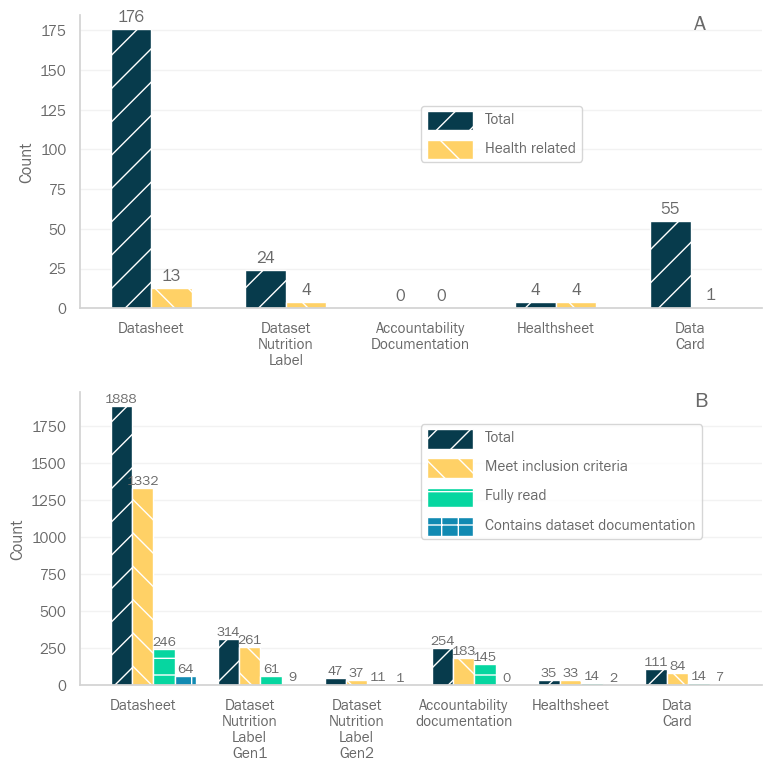

In [5]:
def get_axis_limits(ax):
    return (
        ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.9,
        ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95,
    )


documentation_approach_list = [
    "Datasheet",
    "Dataset Nutrition Label",
    "Accountability Documentation",
    "Healthsheet",
    "Data Card",
]
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Count per documentation approach
count_total = []
count_health_related = []
labels = []

for documentation_approach in documentation_approach_list:
    count_total.append(len(df[df["documentationApproach"] == documentation_approach]))
    count_health_related.append(
        len(
            df[
                (df["documentationApproach"] == documentation_approach)
                & (df["isHealthDataset"] == "yes")
            ]
        )
    )
    if len(documentation_approach.split()) > 1:
        documentation_approach = "\n".join(documentation_approach.split())
    labels.append(documentation_approach)

ax = axs[0]
width = 0.3
x = np.arange(len(labels))
y_list = [count_total, count_health_related]
labels_list = ["Total", "Health related"]
count = 0
for y in y_list:
    bars = ax.bar(
        x + width * count,
        y,
        width,
        color=colors[count],
        hatch=patterns[count],
        label=labels_list[count],
    )
    ax.bar_label(bars, padding=3, fontsize=12)
    count += 1

ax.set_xticks(x + width / 2, labels)
ax.set_ylabel("Count", fontsize=12)
ax.set_axisbelow(True)
leg = ax.legend(loc=(0.5, 0.5), labelspacing=1, handlelength=3, facecolor="white")
for patch in leg.get_patches():
    patch.set_height(14)
    patch.set_y(-5)
ax.grid(axis="y", color="0.95")
ax.grid(axis="y", color="0.95")
ax.annotate("A", xy=get_axis_limits(ax))

# Method 2 citations analysis
labels_list = [
    "Total",
    "Meet inclusion criteria",
    "Fully read",
    "Contains dataset documentation",
]
relevant_columns = [
    "totalCitations",
    "meetInclusionCriteriaCount",
    "meetCodeCriteriaForFullReadCount",
    "containsDatasetDocumentationCount",
]
labels = []
for documentation_approach in list(df_citations["datasetDocumentationApproach"].values):
    if len(documentation_approach.split()) > 1:
        documentation_approach = "\n".join(documentation_approach.split())
    labels.append(documentation_approach)

ax = axs[1]
width = 0.2
x = np.arange(len(labels))
for count in range(len(relevant_columns)):
    y = df_citations[relevant_columns[count]]
    bars = ax.bar(
        x + width * count,
        y,
        width,
        color=colors[count],
        hatch=patterns[count],
        label=labels_list[count],
    )
    ax.bar_label(bars, padding=1, fontsize=10)

ax.set_xticks(x + width, labels)
ax.set_ylabel("Count", fontsize=12)
ax.set_axisbelow(True)
leg = ax.legend(loc=(0.5, 0.5), labelspacing=1, handlelength=3, facecolor="white")
for patch in leg.get_patches():
    patch.set_height(14)
    patch.set_y(-5)
ax.grid(axis="y", color="0.95")
ax.annotate("B", xy=get_axis_limits(ax))

fig.tight_layout()
fig.savefig("outputs/real_world_usage_overview.png", dpi=200)

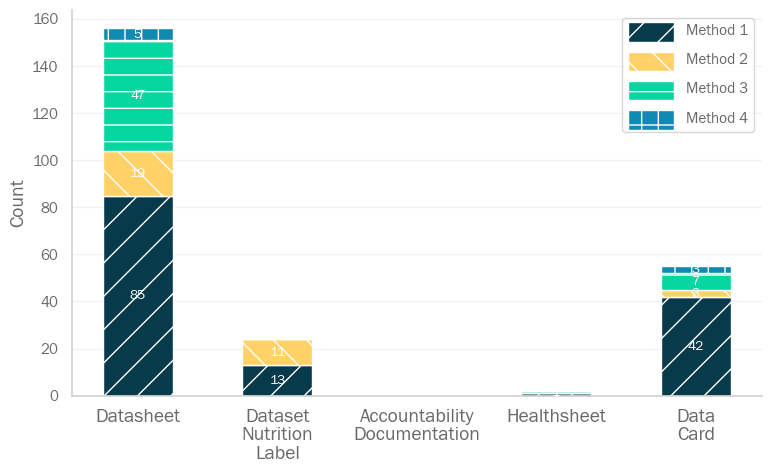

In [27]:
# Bonus
labels = []
count_method_1 = []
count_method_2 = []
count_method_3 = []
count_method_4 = []

for documentation_approach in documentation_approach_list:
    count_method_1.append(
        len(
            df[
                (df["documentationApproach"] == documentation_approach)
                & (df["searchMethod"].str.contains("1"))
            ]
        )
    )
    count_method_2.append(
        len(
            df[
                (df["documentationApproach"] == documentation_approach)
                & (df["searchMethod"].str.contains("2"))
            ]
        )
    )
    count_method_3.append(
        len(
            df[
                (df["documentationApproach"] == documentation_approach)
                & (df["searchMethod"].str.contains("3"))
            ]
        )
    )
    count_method_4.append(
        len(
            df[
                (df["documentationApproach"] == documentation_approach)
                & (df["searchMethod"].str.contains("4"))
            ]
        )
    )
    if len(documentation_approach.split()) > 1:
        documentation_approach = "\n".join(documentation_approach.split())
    labels.append(documentation_approach)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
width = 0.5
x = np.arange(len(labels))
y_list = [count_method_1, count_method_2, count_method_3, count_method_4]
labels_list = ["Method 1", "Method 2", "Method 3", "Method 4"]
bottom = np.zeros(5)
count = 0
for y in y_list:
    ax.bar(
        x,
        y,
        width,
        bottom=bottom,
        color=colors[count],
        hatch=patterns[count],
        label=labels_list[count],
    )
    count += 1
    bottom = bottom + np.array(y)

for c in ax.containers:
    bar_labels = [int(a) if a else "" for a in c.datavalues]
    ax.bar_label(c, labels=bar_labels, label_type="center", fontsize=10, color="white")

ax.set_xticks(x, labels, fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_axisbelow(True)
leg = ax.legend(loc="upper right", labelspacing=1, handlelength=3, facecolor="white")
for patch in leg.get_patches():
    patch.set_height(14)
    patch.set_y(-5)
ax.grid(axis="y", color="0.95")

fig.tight_layout()
fig.savefig("outputs/real_world_usage_method.png", dpi=200)